# EMNIST Data Classification

# EMNIST Classification

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
# import tensorflow as tf
import torch
import random
import seaborn as sns
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import math
# from tensorflow.keras import models, layers
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Subset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

## Hardware Check

checks our available computing resources. detects if a GPU is present, and automatically configures our environment to use the GPU if available, falling back to the CPU otherwise.

In [ ]:
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("CUDA version:", torch.version.cuda)
    print("GPU device:", torch.cuda.get_device_name(0))
    print("GPU count:", torch.cuda.device_count())

print(torch.cuda.is_available())  # True if GPU detected
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


### Setting the Random Seed

ensures experiments are reproducible by fixing the random number generators to a specific starting point (**SEED**).

In [3]:
# Choose a fixed seed value
SEED = 42

# Python's built-in random module
random.seed(SEED)
# NumPy's random number generator
np.random.seed(SEED)
# PyTorch on the CPU
torch.manual_seed(SEED)

# GPU operations (if using CUDA)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    # For multi-GPU
    torch.cuda.manual_seed_all(SEED)
    # Enable deterministic behavior for CuDNN (slower, but necessary for full reproducibility)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


when using multi-processing for data loading (i.e., num_workers > 0), the standard global seed setting is not enough because each worker process will start with the same seed, causing them to generate identical random indices and, potentially, identical data augmentations.

must pass a function to the worker_init_fn parameter to ensure each worker has a unique, deterministic seed.

In [4]:
def worker_init_fn(worker_id):
    """Function to initialize the random seed for each DataLoader worker."""
    # The DataLoader's base seed + worker_id gives a unique seed for each worker
    # worker_seed = SEED % 2**32 + worker_id
    # worker_seed = SEED
    # np.random.seed(worker_seed)
    # random.seed(worker_seed)

    # seed = torch.initial_seed() % 2**32
    worker_info = torch.utils.data.get_worker_info()
    seed = worker_info.seed % 2**32  # 32-bit safe seed
    np.random.seed(seed)
    random.seed(seed)

## 1. Data Preprocessing

In [5]:
EMNIST_SPLIT = 'byclass'
BATCH_SIZE = 400
VAL_RATIO = 0.1

Defines a data transformation pipeline that prepares and augments our images for training.

We will applies several modifications to make the model more robust:
- **RandomPerspective**: Warps images slightly to simulate different viewing angles
- **RandomAdjustSharpness**: Varies image sharpness to mimic quality differences

Processing for training:
- **ToTensor**: Converts images to the tensor format PyTorch requires
- **Normalize**: Standardizes pixel values using EMNIST's known statistics for faster, more stable training

In [6]:
transform = transforms.Compose([
  # transforms.RandomRotation([-90, -90]),
  transforms.RandomPerspective(distortion_scale=0.4, p=0.4),
  transforms.RandomAdjustSharpness(sharpness_factor=0.7, p=0.4),
  transforms.ToTensor(),
  transforms.Normalize((0.1307,), (0.3081,)),
  # transforms.Lambda(lambda x: x.transpose(1, 2))

])

Loading the EMNIST dataset using `torchvision`, which contains handwritten characters and digits:

- **full_train_dataset**: The training portion of the data
- **test_dataset**: The testing portion

Both datasets use the same character/digit split (*`EMNIST_SPLIT`*) and apply the same image transformations for consistency. 
The `download=True` parameter ensures the data is automatically downloaded if not already present in the specified root directory.

In [7]:
full_train_dataset = datasets.EMNIST(
  root=f'./',
  split=EMNIST_SPLIT,
  train=True,
  download=True,
  transform=transform
)

test_dataset = datasets.EMNIST(
  root=f'./',
  split=EMNIST_SPLIT,
  train=False,
  download=True,
  transform=transform
)

Create a validation split out of our training data for performance measurement

In [8]:
dataset_size = len(full_train_dataset)

train_indices, val_indices = train_test_split(
  list(range(dataset_size)),
  test_size=VAL_RATIO,
  stratify=full_train_dataset.targets,
  random_state=SEED
)

val_dataset = Subset(full_train_dataset, val_indices)
train_dataset = Subset(full_train_dataset, train_indices)


In [9]:
print(f"Dataset sizes:")
print(f"Training: {len(train_dataset)} samples")
print(f"Validation: {len(val_dataset)} samples")
print(f"Test: {len(test_dataset)} samples")

Dataset sizes:
Training: 628138 samples
Validation: 69794 samples
Test: 116323 samples


Creates a data loader for the dataset (data feeder), efficiently handles large datasets by loading them in chunks rather than all at once:

- **Batches the data**
- **Shuffles the data**
- **Optimizes for GPU**: Uses pin_memory to speed up data transfer to GPU, and multiple workers to load data in parallel

In [74]:
train_loader = DataLoader(
  dataset=train_dataset,
  batch_size=BATCH_SIZE,
  shuffle=True,
  num_workers=2,
  # worker_init_fn=worker_init_fn,
  pin_memory=True if device.type == 'cuda' else False
)

val_loader = DataLoader(
  dataset=val_dataset,
  batch_size=BATCH_SIZE,
  shuffle=False,
  num_workers=2,
  # worker_init_fn=worker_init_fn,
  pin_memory=True if device.type == 'cuda' else False
)

test_loader = DataLoader(
  dataset=test_dataset,
  batch_size=BATCH_SIZE,
  shuffle=False,
  num_workers=2,
  # worker_init_fn=worker_init_fn,
  pin_memory=True if device.type == 'cuda' else False
)

## 2. Exploratory Data Analysis (EDA)

Define the Label of the class

In [ ]:
EMNIST_MAPPING = "0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"
# EMNIST_MAPPING = "abcdefghijklmnopqrstuvwxyz"

Displays a grid of sample images from the EMNIST dataset to help us understand what we're working with.

* Randomly picks a specified number of images from the dataset and shows them in a clean layout. For each image, it displays the actual picture and its corresponding label - converting the numerical label back into the actual character or digit it represents by mapping it to `EMNIST_MAPPING`.

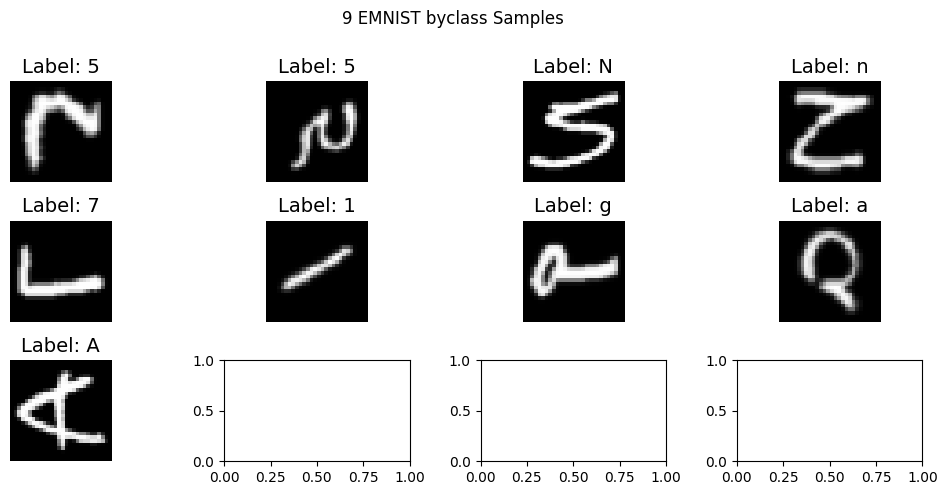

In [ ]:
def visualize_sample(dataset, num_samples=11):
  ncol_ = int(num_samples*0.5)
  nrow_ = math.ceil(num_samples / ncol_)
  fig, axes = plt.subplots(nrow_, ncol_, figsize=(10,5))
  fig.suptitle(f"{num_samples} EMNIST {EMNIST_SPLIT} Samples")

  axes = axes.flatten()

  for i in range(num_samples):
    img, label_idx = dataset[i]

    np_image = img.squeeze().numpy()

    try:
      label_char = f"Label: {EMNIST_MAPPING[label_idx]}"
    except IndexError:
      label_char = f"Label index: {label_idx}"

    axes[i].imshow(np_image, cmap='grey')
    axes[i].set_title(label_char, fontsize=14)
    axes[i].axis('off')

  for j in range(num_samples, nrow_ * ncol_):
    fig.delaxes(axes[j])
  
  plt.tight_layout(rect=[0,0,1,0.98])
  plt.show()

visualize_sample(train_dataset, 9)

### 2.1 Analyze Class Distribution (Counting Labels)

Briefly taking a view of our data distribution.

In [13]:
def plot_distribution_bar(x, y):
    x_key = "Label"
    y_key = "Count"

    cmap = plt.get_cmap('viridis')
    colors = cmap(np.linspace(0, 1, len(x)))

    plt.figure(figsize=(6, 3))
    plt.bar(x, y, color=colors)
    plt.title(f"EMNIST {EMNIST_SPLIT} Data Distribution")
    plt.xlabel(x_key)
    plt.ylabel(y_key)
    plt.show()

In [15]:
train_labels = full_train_dataset.targets[train_dataset.indices].numpy()

unique_labels, unique_counts = np.unique(train_labels, return_counts=True)


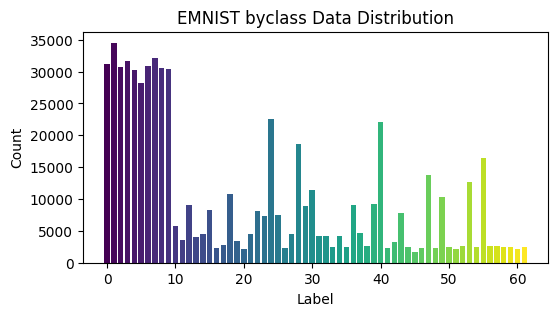

In [16]:
plot_distribution_bar(unique_labels, unique_counts)

Although we observed a degree of imbalance (or skew), and upsampling is a common technique to mitigate this, we have elected not to apply any resampling at this stage.

### 2.2 Inspect Data Statistics

In [14]:
def number_to_ordinal(n):
  """
  Converts an integer into its ordinal representation.
  """
  n = int(n)
  if 10 <= n % 100 <= 20:
      suffix = "th"
  else:
      suffix = {1: "st", 2: "nd", 3: "rd"}.get(n % 10, "th")
  return f"{n}{suffix}"

def get_batches_statistics(n_batch):
  train_iter = iter(train_loader)
  if n_batch > len(train_iter):
    n_batch = len(train_iter)

  for i in range(n_batch):
    img, label = next(train_iter)

    print(f"\n--- Pixel Statistics ({number_to_ordinal(i+1)} Batch) ---")
    print(f"Min Pixel Value: {img.min().item():.4f}")
    print(f"Max Pixel Value: {img.max().item():.4f}")
    print(f"Mean Pixel Value: {img.mean().item():.4f}")
    print(f"Std Dev of Pixel Values: {img.std().item():.4f}")

Use the batch to calculate basic statistics like the minimum, maximum, mean, and standard deviation of the pixel values.

In [18]:
get_batches_statistics(n_batch=2)


--- Pixel Statistics (1st Batch) ---
Min Pixel Value: -0.4242
Max Pixel Value: 2.8215
Mean Pixel Value: 0.0729
Std Dev of Pixel Values: 1.0004

--- Pixel Statistics (2nd Batch) ---
Min Pixel Value: -0.4242
Max Pixel Value: 2.8215
Mean Pixel Value: 0.0664
Std Dev of Pixel Values: 0.9945


## Model Architecture

In [15]:
num_classes = len(EMNIST_MAPPING)

Defines a Convolutional Neural Network (CNN) with two main parts:

**Features Model (Feature Extractor)**
- **Conv2d**: Learns visual patterns
- **BatchNorm2d**: Stabilizes training by normalizing layer outputs  
- **ReLU**: Adds non-linearity to learn complex patterns
- **MaxPool2d**: Reduces image size while keeping important features
- **Dropout**: Prevents overfitting by randomly disabling neurons
- **AdaptiveAvgPool2d**: Converts final features to fixed size

**Classifier Model (Decision Maker)**
- **Linear**: Fully connected layers that combine features
- **BatchNorm1d**: Normalizes the dense layer outputs
- **Dropout**: Higher dropout in final layers for regularization

Progressively extracts visual features, then uses them to make classification decisions.

In [ ]:
features_model = nn.Sequential(
  nn.Conv2d(1, 32, 3, padding=1),
  nn.BatchNorm2d(32),
  nn.ReLU(inplace=True),
  nn.Conv2d(32, 32, 3, padding=1),
  nn.BatchNorm2d(32),
  nn.ReLU(inplace=True),
  nn.Conv2d(32, 32, 3, padding=1),
  nn.BatchNorm2d(32),
  nn.ReLU(inplace=True),
  nn.Conv2d(32, 32, 3, padding=1),
  nn.BatchNorm2d(32),
  nn.ReLU(inplace=True),
  nn.MaxPool2d(2),
  nn.Dropout(0.25),

  nn.Conv2d(32, 64, 3, padding=1),
  nn.BatchNorm2d(64),
  nn.ReLU(inplace=True),
  nn.Conv2d(64, 64, 3, padding=1),
  nn.BatchNorm2d(64),
  nn.ReLU(inplace=True),
  nn.Conv2d(64, 64, 3, padding=1),
  nn.BatchNorm2d(64),
  nn.ReLU(inplace=True),
  nn.Conv2d(64, 64, 3, padding=1),
  nn.BatchNorm2d(64),
  nn.ReLU(inplace=True),
  nn.MaxPool2d(2),
  nn.Dropout(0.25),

  nn.Conv2d(64, 128, 3, padding=1),
  nn.BatchNorm2d(128),
  nn.ReLU(inplace=True),
  nn.Conv2d(128, 128, 3, padding=1),
  nn.BatchNorm2d(128),
  nn.ReLU(inplace=True),
  nn.Conv2d(128, 128, 3, padding=1),
  nn.BatchNorm2d(128),
  nn.ReLU(inplace=True),
  nn.MaxPool2d(2),
  nn.Dropout(0.25),

  nn.Conv2d(128, 256, 3, padding=1),
  nn.BatchNorm2d(256),
  nn.ReLU(inplace=True),
  nn.Conv2d(256, 256, 3, padding=1),
  nn.BatchNorm2d(256),
  nn.ReLU(inplace=True),
  nn.MaxPool2d(2),
  nn.Dropout(0.25),

  nn.Conv2d(256, 512, 3, padding=1),
  nn.BatchNorm2d(512),
  nn.ReLU(inplace=True),
  nn.AdaptiveAvgPool2d((2, 2)),
  nn.Dropout(0.25)
)

classifier_model = nn.Sequential(
  nn.Linear(512 * 2 * 2, 512),
  nn.BatchNorm1d(512),
  nn.ReLU(inplace=True),
  nn.Dropout(0.25),

  nn.Linear(512, 256),
  nn.BatchNorm1d(256),
  nn.ReLU(inplace=True),
  nn.Dropout(0.5),

  nn.Linear(256, num_classes)
)

In [37]:
total_params = sum(p.numel() for p in features_model.parameters()) + sum(p.numel() for p in classifier_model.parameters())
print(f"Model initialized with {num_classes} classes")
print(f"Total parameters: {total_params:,}")

Model initialized with 62 classes
Total parameters: 3,793,246


Define a function to handle the initialization of our network's weights.

**Weight Initialization**
Initializes the neural network's weights to help training converge faster and more reliably. Uses different strategies for different layer types:
- **Conv2d**: *Kaiming initialization* for ReLU activation
- **BatchNorm**: Sets weights to 1 and biases to 0  
- **Linear**: Small random weights with zero bias

**Forward Pass Function**
This defines how data flows through the model:
- Passes input through the feature extractor
- Flattens the 2D features into 1D
- Feeds them to the classifier for final predictions

Proper initialization prevents gradient issues and ensures stable training from the start.

In [38]:
def initialize_weights(module):
  for m in module:
    if isinstance(m, nn.Conv2d):  
      nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
      if m.bias is not None:
        nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.BatchNorm2d):  
      nn.init.constant_(m.weight, 1)
      nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.Linear):  
      nn.init.normal_(m.weight, 0, 0.01)
      nn.init.constant_(m.bias, 0)

def forward(features, classifier, x):
    """Forward pass through the model"""
    x = features(x)
    x = x.view(x.size(0), -1)
    x = classifier(x)
    return x

In [39]:
initialize_weights(features_model)
initialize_weights(classifier_model)


## Training Our Model

In [40]:
PATIENCE = 7
N_EPOCHS = 10
LEARNING_RATE = 0.001

In [41]:
list(features_model.parameters())[1].numel()

32

Function to save the trained model and its training history to a file.
- **Model weights**: The learned parameters from both the feature extractor and classifier
- **Training history**: The loss and accuracy metrics from each training epoch

This allows you to reload the model later for inference or to resume training, and also analyze how the training progressed over time.

In [46]:
def save_model_parameters(
  features_model, classifier_model, train_losses, train_accuracies, val_losses, val_accuracies, filepath
):
  """
  Save model with metadata
  """
  torch.save({
    'features_state_dict': features_model.state_dict(),
    'classifier_state_dict': classifier_model.state_dict(),
    'training_history': {
      'train_losses': train_losses,
      'train_accuracies': train_accuracies,
      'val_losses': val_losses,
      'val_accuracies': val_accuracies,
    }
  }, filepath)

  print(f"Model saved to {filepath}")

### Training steps

**1. Setup**
- Sets both models to training mode
- Initializes metrics tracking  

**2. Batch Processing Loop**
- Moves data to GPU/CPU
- Clears previous gradients
- Runs forward pass to get predictions
- Calculates loss between predictions and true labels

**3. Learning**
- Performs backpropagation to calculate gradients
- Clips gradients to prevent explosion
- Updates model weights using optimizer

**4. Metrics Calculation**
- Tracks running loss and accuracy
- Compares predictions with true labels
- Returns average loss and accuracy for the epoch

In [ ]:
def train_epoch(features_model, classifier_model, train_loader, optimizer, criterion, device):
  features_model.train()
  classifier_model.train()

  running_loss = 0.0
  correct = 0
  total = 0

  for batch_idx, (data, targets) in enumerate(train_loader):
    data, targets = data.to(device), targets.to(device)

    optimizer.zero_grad()
    outputs = forward(features_model, classifier_model, data)
    loss = criterion(outputs, targets)
    loss.backward()

    # Gradient clipping
    torch.nn.utils.clip_grad_norm_(list(features_model.parameters()) + list(classifier_model.parameters()), max_norm=1.0)
    optimizer.step()

    running_loss += loss.item()
    _, predicted = outputs.max(1)
    total += targets.size(0)
    correct += predicted.eq(targets).sum().item()

  epoch_loss = running_loss / len(train_loader)
  epoch_accuracy = 100. * correct / total

  return epoch_loss, epoch_accuracy

### Evaluation steps
To assesses how well the model generalizes to unseen data, We need to evaluate our model on the validation set without training

**1. Setup**
- Sets models to evaluation mode (disables dropout/batchnorm tracking)
- Initializes metrics tracking

**2. Inference Loop**
- Uses `torch.no_grad()` to disable gradient calculations for efficiency
- Moves data to the appropriate device
- Runs forward pass to get predictions
- Calculates loss between predictions and true labels

**3. Metrics Calculation**
- Accumulates loss across all batches
- Counts correct predictions by comparing predicted vs true labels
- Computes average loss and accuracy for the epoch

In [48]:
def validate_epoch(features_model, classifier_model, val_loader, criterion, device):
  features_model.eval()
  classifier_model.eval()

  running_loss = 0.0
  correct = 0
  total = 0

  with torch.no_grad():
    for data, targets in (val_loader):
      data, targets = data.to(device), targets.to(device)
      outputs = forward(features_model, classifier_model, data)
      loss = criterion(outputs, targets)

      running_loss += loss.item()
      _, predicted = outputs.max(1)
      total += targets.size(0)
      correct += predicted.eq(targets).sum().item()

  epoch_loss = running_loss / len(val_loader)
  epoch_accuracy = 100. * correct / total

  return epoch_loss, epoch_accuracy

### Training pipeline

**1. Initialization**
- Moves models to the correct device (GPU/CPU)
- Sets up loss function, optimizer, and learning rate scheduler
- Initializes tracking variables for metrics and early stopping

**2. Training Loop**
- For each epoch, trains the model and validates its performance
- Adjusts learning rate automatically based on validation performance
- Tracks training and validation metrics

**3. Model Selection & Early Stopping**
- Saves the best model weights whenever validation accuracy improves
- Implements early stopping if no improvement occurs for several epochs
- Restores the best model weights at the end of training

**4. Monitoring**
- Prints detailed progress including losses, accuracies, and learning rate
- Saves the best performing model checkpoint

In [ ]:
def train_model(features_model, classifier_model, train_loader, val_loader, test_loader, classes):
  features_model.to(device)
  classifier_model.to(device)

  train_losses = []
  train_accuracies = []
  val_losses = []
  val_accuracies = []
  best_val_accuracy = 0
  best_features_state = None
  best_classifier_state = None
  early_stopping_counter = 0

  criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
  optimizer = optim.AdamW(
    list(features_model.parameters()) + list(classifier_model.parameters()),
    lr=LEARNING_RATE,
    weight_decay=1e-4
  )

  scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=3
  )

  for epoch in range(N_EPOCHS):
    print(f'Epoch [{epoch+1:02d}/{N_EPOCHS}]')

    train_loss, train_accuracy = train_epoch(
      features_model, classifier_model, train_loader, optimizer, criterion, device
    )

    val_loss, val_accuracy = validate_epoch(
      features_model, classifier_model, val_loader, criterion, device
    )

    scheduler.step(val_accuracy)

    # Store metrics
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Early Stopping check
    if val_accuracy > best_val_accuracy:
      best_val_accuracy = val_accuracy
      best_features_state = features_model.state_dict().copy()
      best_classifier_state = classifier_model.state_dict().copy()
      early_stopping_counter = 0

      # Save best model
      save_model_parameters(
        features_model,
        classifier_model,
        train_losses,
        train_accuracies,
        val_losses,
        val_accuracies,
        f'best_emnist_model_20251109.pth'
      )
    else:
      early_stopping_counter += 1

    current_lr = optimizer.param_groups[0]['lr']
    print(f'LR: {current_lr:.6f}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%')
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')
    print(f'Best Val Acc: {best_val_accuracy:.2f}%, Early Stopping: {early_stopping_counter}/{PATIENCE}')
    print('-' * 60)

    if early_stopping_counter >= PATIENCE:
      print(f"Early stopping triggered after {epoch+1} epochs")
      break

  if best_features_state is not None and best_classifier_state is not None:
    features_model.load_state_dict(best_features_state)
    classifier_model.load_state_dict(best_classifier_state)

  return train_losses, train_accuracies, val_losses, val_accuracies


In [50]:
train_losses, train_accuracies, val_losses, val_accuracies = train_model(
  features_model, classifier_model, train_loader, val_loader, test_loader, EMNIST_MAPPING
)


Epoch [01/10]
Model saved to best_emnist_model_20251109.pth
LR: 0.001000, Train Loss: 1.1461, Train Acc: 84.36%
Val Loss: 1.0818, Val Acc: 84.95%
Best Val Acc: 84.95%, Early Stopping: 0/7
------------------------------------------------------------
Epoch [02/10]
Model saved to best_emnist_model_20251109.pth
LR: 0.001000, Train Loss: 1.1176, Train Acc: 85.27%
Val Loss: 1.0564, Val Acc: 86.12%
Best Val Acc: 86.12%, Early Stopping: 0/7
------------------------------------------------------------
Epoch [03/10]
Model saved to best_emnist_model_20251109.pth
LR: 0.001000, Train Loss: 1.1042, Train Acc: 85.69%
Val Loss: 1.0467, Val Acc: 86.36%
Best Val Acc: 86.36%, Early Stopping: 0/7
------------------------------------------------------------
Epoch [04/10]
LR: 0.001000, Train Loss: 1.0951, Train Acc: 85.96%
Val Loss: 1.0509, Val Acc: 86.25%
Best Val Acc: 86.36%, Early Stopping: 1/7
------------------------------------------------------------
Epoch [05/10]
Model saved to best_emnist_model_202

In [ ]:
# del features_model
# del classifier_model

# Clear GPU cache
if torch.cuda.is_available():
    torch.cuda.empty_cache()

## Evaluation

### Load pretrained model

loads a previously saved model and its training history:

- **Loads checkpoint**: Reads the saved file containing model weights and training metrics
- **Restores models**: Applies the saved weights to both the feature extractor and classifier
- **Recovers history**: Retrieves the loss and accuracy records from training
- **Returns metrics**: Provides the training/validation history for analysis

In [ ]:
def load_model(filepath, features_model, classifier_model):
  train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []
  checkpoint = torch.load(filepath)

  features_model.load_state_dict(checkpoint['features_state_dict'])
  classifier_model.load_state_dict(checkpoint['classifier_state_dict'])

  training_history = checkpoint['training_history']
  train_losses = training_history['train_losses']
  train_accuracies = training_history['train_accuracies']
  val_losses = training_history['val_losses']
  val_accuracies = training_history['val_accuracies']

  return train_losses, train_accuracies, val_losses, val_accuracies

In [54]:
train_losses, train_accuracies, val_losses, val_accuracies = load_model('best_emnist_model_20251109.pth', features_model, classifier_model)

In [53]:
def plot_training_history(train_losses, train_accuracies, val_losses, val_accuracies):
  fig, axes = plt.subplots(2, 1, figsize=(8, 4))
  axes = axes.flatten()

  axes[0].plot(train_losses, label='Training Loss')
  axes[0].plot(val_losses, label='Validation Loss')
  axes[0].set_xlabel('Epoch')
  axes[0].set_ylabel('Loss')
  axes[0].set_title("Train & Val Losses")
  axes[0].legend()
  axes[0].grid(True)

  axes[1].plot(train_accuracies, label='Training Accuracy')
  axes[1].plot(val_accuracies, label='Validation Accuracy')
  axes[1].set_xlabel('Epoch')
  axes[1].set_ylabel('Accuracy (%)')
  axes[1].set_title("Train & Val Accuracies")
  axes[1].legend()
  axes[1].grid(True)

  plt.tight_layout()
  plt.show()


Generates the indices and labels for a subset of classes 
based on a string input.  

Args:
* ***full_mapping (list)***: The complete list of all class labels (EMNIST_MAPPING).  
* ***desired_labels_string (str)***: A string containing the specific labels 
                                to include in the subset (e.g., '012A').  

Returns:
* tuple: (subset_indices, subset_labels)

In [ ]:
def get_confusion_matrix_subset(full_mapping, desired_labels_string=''):
 
  subset_indices = []
  subset_labels = []
  
  # Convert the desired labels string into a set for fast lookup
  desired_set = set(desired_labels_string)
  
  # Iterate through the full mapping
  for index, label in enumerate(full_mapping):
    if desired_set:
      if label in desired_set:
          subset_indices.append(index)
          subset_labels.append(label)
    else:
      subset_indices.append(index)
      subset_labels.append(label)
          
  subset_indices.sort()
  subset_labels.sort()
  return subset_indices, subset_labels

* runs inference to collect predictions and true labels
* calculates key metrics (accuracy, precision, recall, F1-score) using weighted averaging
* returns the complete performance assessment to show how well the model generalizes

In [56]:
def evaluation(features_model, classifier_model, test_loader, device):
  features_model.eval()
  classifier_model.eval()

  features_model.to(device)
  classifier_model.to(device)

  all_predictions = []
  all_targets = []
  all_probabilities = []

  with torch.no_grad():
    for data, targets in test_loader:
      data, targets = data.to(device), targets.to(device)
      outputs = forward(features_model, classifier_model, data)
      probabilities = torch.softmax(outputs, dim=1)
      _, predicted = outputs.max(1)

      all_predictions.extend(predicted.cpu().numpy())
      all_targets.extend(targets.cpu().numpy())
      all_probabilities.extend(probabilities.cpu().numpy())

  accuracy = accuracy_score(all_targets, all_predictions)
  precision = precision_score(all_targets, all_predictions, average='weighted', zero_division=1)
  recall = recall_score(all_targets, all_predictions, average='weighted', zero_division=1)
  f1 = f1_score(all_targets, all_predictions, average='weighted')

  print("\n" + "="*60)
  print("COMPREHENSIVE EVALUATION RESULTS")
  print("="*60)
  print(f"Test Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
  print(f"Precision: {precision:.4f}")
  print(f"Recall: {recall:.4f}")
  print(f"F1-Score: {f1:.4f}")
  
  return all_predictions, all_targets, all_probabilities


In [57]:
all_predictions, all_targets, all_probabilities = evaluation(features_model, classifier_model, test_loader, device)


COMPREHENSIVE EVALUATION RESULTS
Test Accuracy: 0.8711 (87.11%)
Precision: 0.8710
Recall: 0.8711
F1-Score: 0.8542


In [58]:
# Detailed classification report
print("\nClassification Report:")
print(classification_report(all_targets, all_predictions, 
                          target_names=[str(c) for c in EMNIST_MAPPING], 
                          zero_division=1))



Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.83      0.75      5778
           1       0.67      0.92      0.77      6330
           2       0.94      0.99      0.97      5869
           3       1.00      1.00      1.00      5969
           4       0.98      0.98      0.98      5619
           5       0.98      0.92      0.95      5190
           6       0.96      0.99      0.98      5705
           7       0.99      1.00      0.99      6139
           8       0.99      0.99      0.99      5633
           9       0.92      0.99      0.95      5686
           A       0.95      0.99      0.97      1062
           B       0.93      0.97      0.95       648
           C       0.77      0.98      0.86      1739
           D       0.96      0.88      0.92       779
           E       0.97      0.99      0.98       851
           F       0.79      0.98      0.87      1440
           G       0.95      0.86      0.90       447
   

Creates a focused confusion matrix to analyze specific character predictions.

In [59]:
subset_indices, subset_labels = get_confusion_matrix_subset(EMNIST_MAPPING, 'qwertyusdfghjnhbg4567')
# subset_indices, subset_labels = get_confusion_matrix_subset(EMNIST_MAPPING)

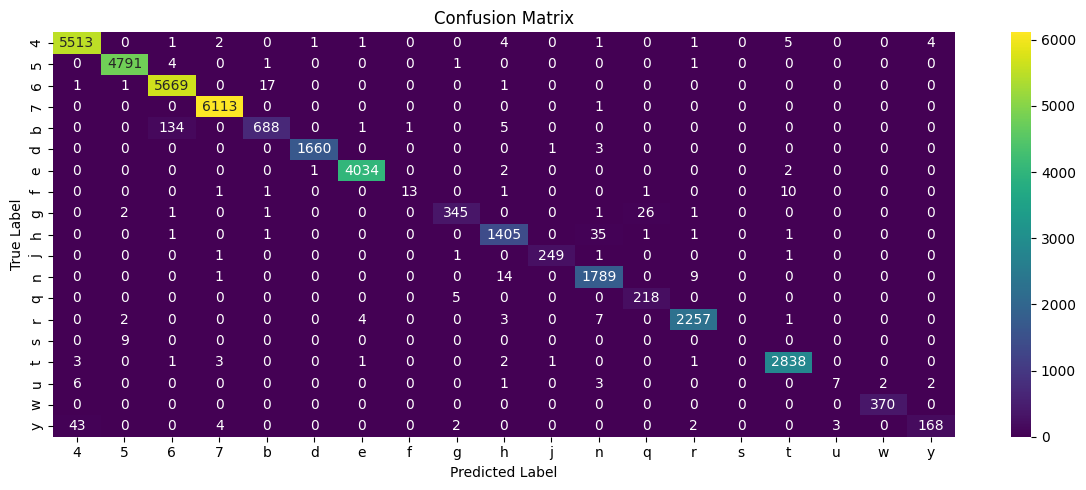

In [60]:
plt.figure(figsize=(max(12, int(len(subset_indices)/3)), max(5, int(len(subset_indices)/3 - 10))))
cm = confusion_matrix(all_targets, all_predictions)
cm_subset = cm[subset_indices, :][:, subset_indices]
sns.heatmap(cm_subset, annot=True, fmt='d', cmap='viridis',
           xticklabels=subset_labels, yticklabels=subset_labels)
plt.title("Confusion Matrix")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

The heatmap visualization makes it easy to spot which characters the model frequently confuses with each other, helping identify patterns in prediction errors.

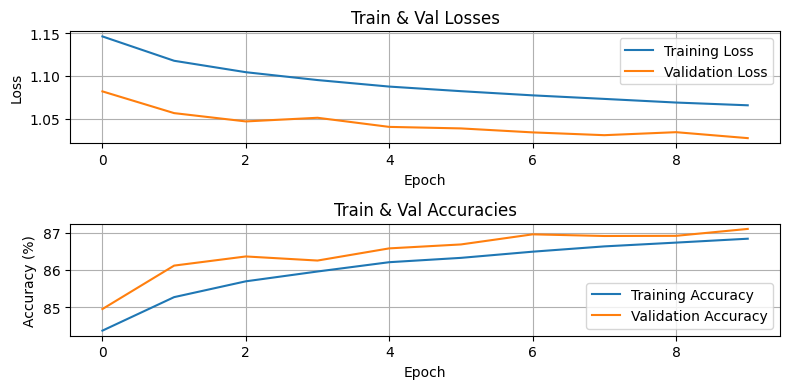

In [61]:
# Plot training history if available
if train_losses is not None and val_losses is not None:
    plot_training_history(train_losses, train_accuracies, val_losses, val_accuracies)


---

In [ ]:
for name, param in features_model.named_modules():
  # if param.requires_grad:
  #   # print(name, param.data)
  #   None
  print(name)


## Inference

### Single image inference

* **Sets models to evaluation mode** and moves to device
* **Adds batch dimension** to the input image tensor
* **Runs forward pass** through both models
* **Converts outputs to probabilities** using softmax
* **Extracts predicted class** and confidence score
* **Maps index to label** using `EMNIST_MAPPING`
* **Returns prediction**, confidence, and full probability distribution

In [ ]:
def predict_one(features_model, classifier_model, img_tensor, device):
  features_model.eval()
  classifier_model.eval()

  features_model.to(device)
  classifier_model.to(device)

  with torch.no_grad():
    img_tensor = img_tensor.unsqueeze(0).to(device)
    output = forward(features_model, classifier_model, img_tensor)
    probabilities = torch.softmax(output, dim=1)
    confidence, predicted_idx = torch.max(probabilities, 1)

    predicted_label = EMNIST_MAPPING[predicted_idx.item()]
    confidence_score = confidence.item()
      
  return predicted_label, confidence_score, probabilities.squeeze().cpu().numpy()


### Inference pipeline

* **Selects random samples** from the test dataset
* **Runs prediction** on each sample using the trained model
* **Displays original images** with true/predicted labels and confidence scores
* **Shows probability distributions** for each prediction
* **Creates a clean comparison** between model predictions and ground truth

In [64]:
def inference(features_model, classifier_model, test_loader, device, n_samples=5):
  test_dataset = test_loader.dataset

  fig_size_x = min(max(8, n_samples+8), 40)
  fig_size_y = min(max(4, int(n_samples/2)+5), 20)
  
  fig, axes = plt.subplots(2, n_samples, figsize=(fig_size_x, fig_size_y))

  for i in range(n_samples):
    idx = np.random.randint(len(test_dataset))
    image, true_label = test_dataset[idx]
    true_label = EMNIST_MAPPING[true_label]

    # inference
    predicted_label, confidence, all_probs = predict_one(features_model, classifier_model, image, device)

    axes[0, i].imshow(image.squeeze().cpu().numpy(), cmap='gray')
    axes[0, i].set_title(f"True: {true_label}\nPred: {predicted_label}\nConf: {confidence:.2f}", fontsize=20)
    axes[0, i].axis('off')

    axes[1, i].bar(range(len(all_probs)), all_probs)
    axes[1, i].set_title("Label Probs")
    axes[1, i].set_xlabel("Label")
    axes[1, i].set_ylabel("Probability")
    axes[1, i].tick_params(axis='x', rotation=45)

  plt.tight_layout()
  plt.show()

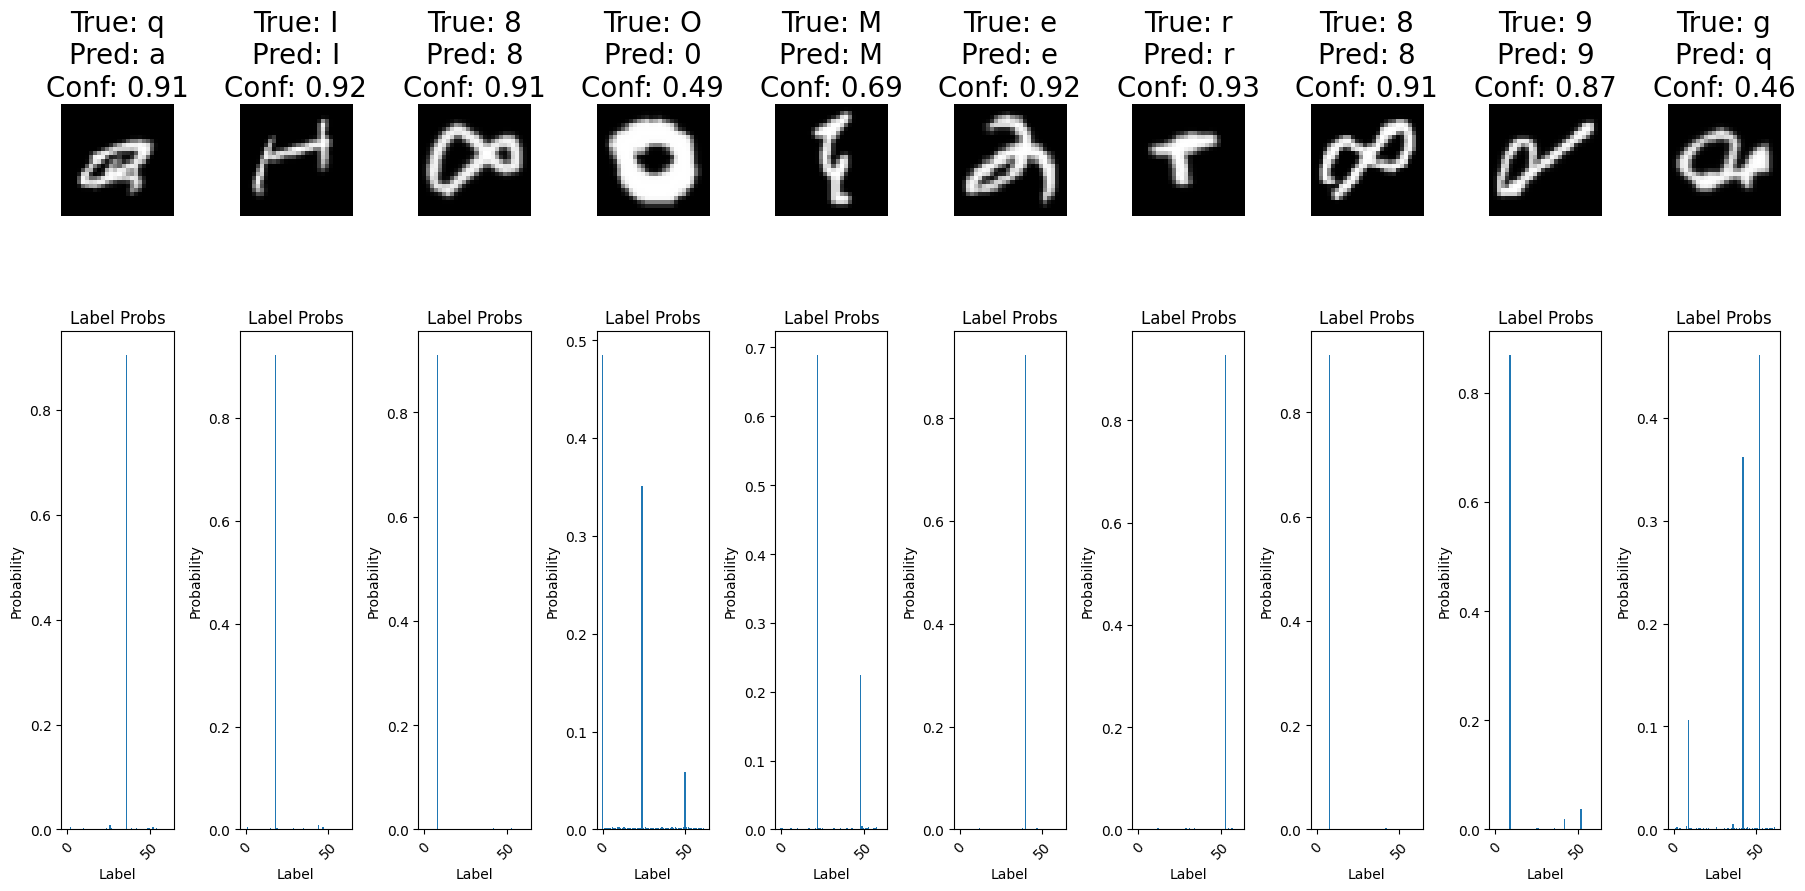

In [65]:
inference(features_model, classifier_model, test_loader, device, 10)

## Appendix

### Filter Visualization - What Patterns Each Filter Detects

Visualize the learned filters/weights in convolutional layers:

* **Iterates through model layers** to find convolutional layers
* **Extracts filter weights** from Conv2d layers and moves to CPU
* **Focuses on 3x3 filters** for visualization
* **Normalizes filter values** to 0-1 range for display
* **Plots filters as images** in a grid layout
* **Labels each filter** for identification

In [66]:
def visualize_conv_filters(model, layer_names=None):
    """
    """
    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d):
            if layer_names is None or name in layer_names:
                weights = module.weight.data.cpu().numpy()
                print(f"Layer: {name}, Filter shape: {weights.shape}")
                
                # For 3x3 filters
                if weights.shape[2] == 3 and weights.shape[3] == 3:
                    num_filters = min(16, weights.shape[0])
                    fig, axes = plt.subplots(2, 8, figsize=(8, 4))
                    fig.suptitle(f'Filters: {name}', fontsize=14)
                    
                    for i, ax in enumerate(axes.flat):
                        if i < num_filters:
                            filter_img = weights[i, 0]  # First input channel
                            # Normalize
                            filter_img = (filter_img - filter_img.min()) / (filter_img.max() - filter_img.min())
                            
                            ax.imshow(filter_img, cmap='gray')
                            ax.set_title(f'F{i}')
                            ax.axis('off')
                        else:
                            ax.axis('off')
                    
                    plt.tight_layout()
                    plt.show()



Layer: 0, Filter shape: (32, 1, 3, 3)


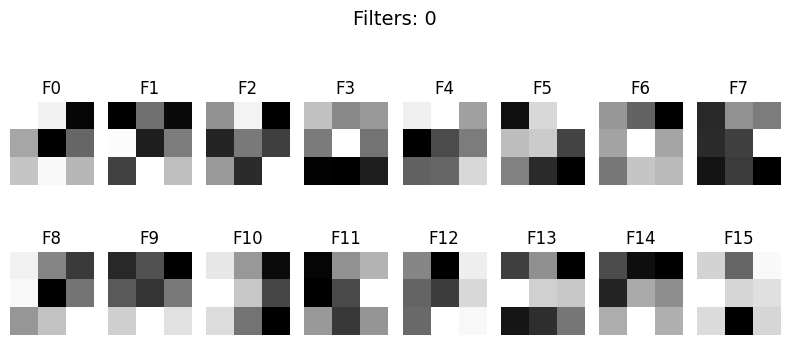

Layer: 3, Filter shape: (32, 32, 3, 3)


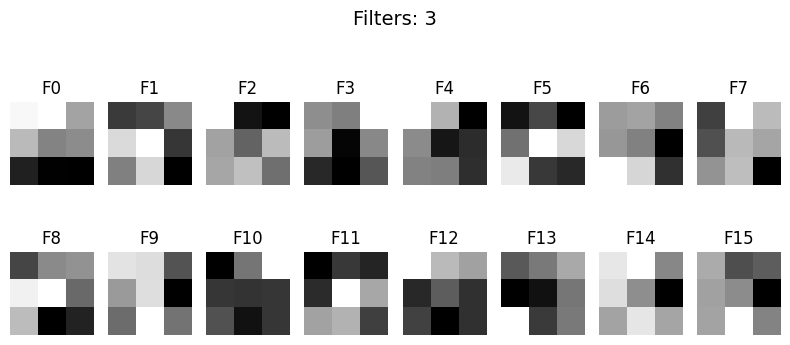

Layer: 6, Filter shape: (32, 32, 3, 3)


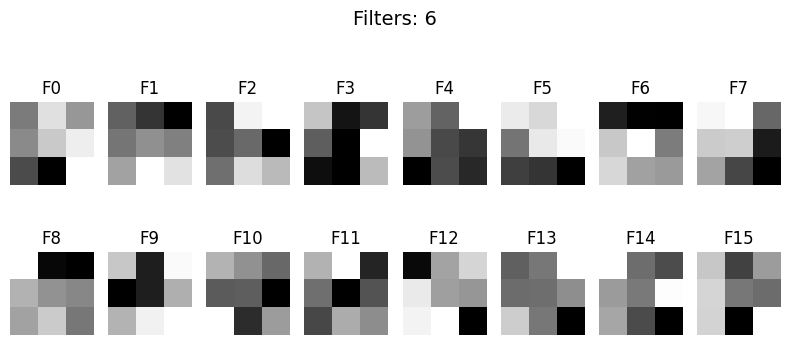

Layer: 9, Filter shape: (32, 32, 3, 3)


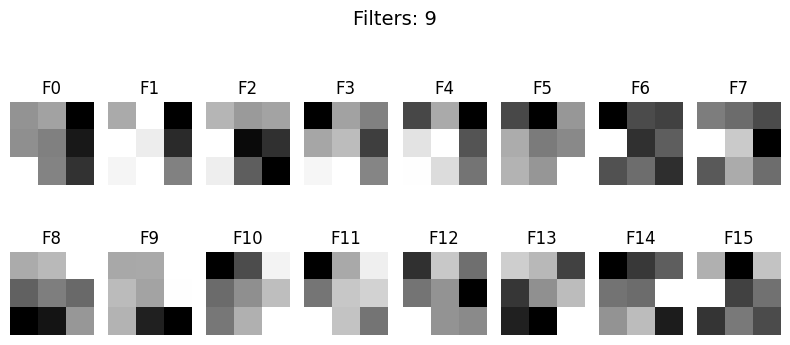

Layer: 14, Filter shape: (64, 32, 3, 3)


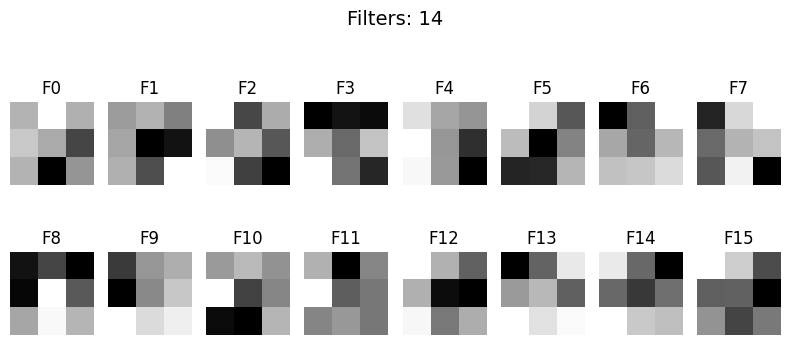

Layer: 17, Filter shape: (64, 64, 3, 3)


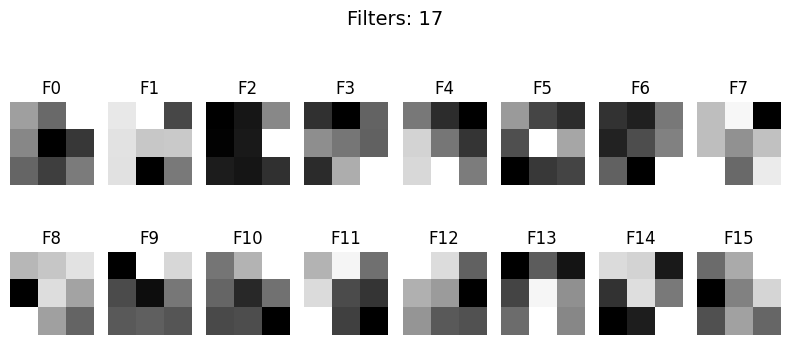

Layer: 20, Filter shape: (64, 64, 3, 3)


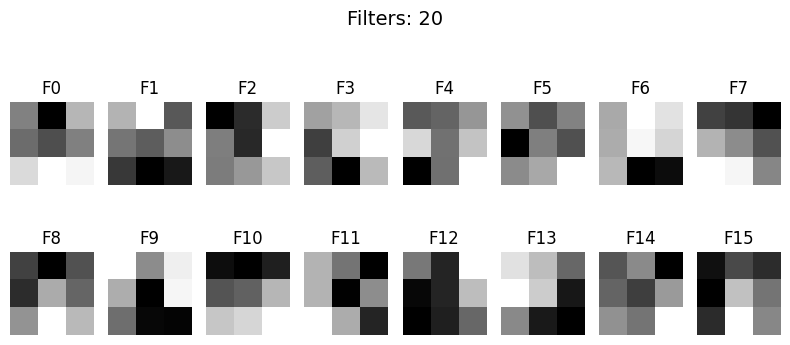

Layer: 23, Filter shape: (64, 64, 3, 3)


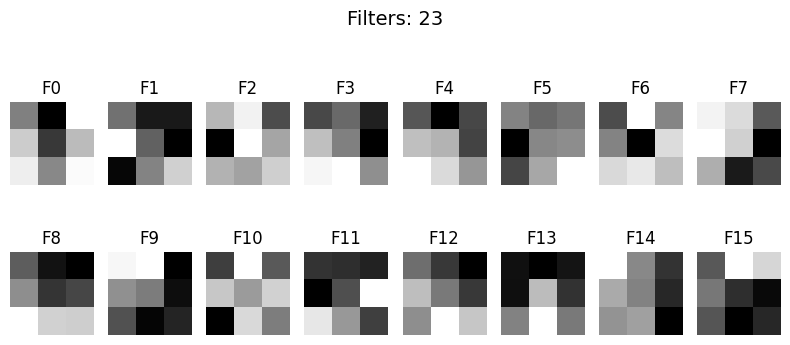

Layer: 28, Filter shape: (128, 64, 3, 3)


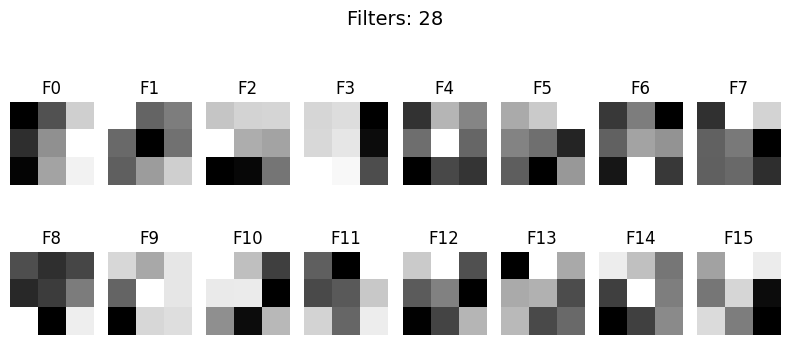

Layer: 31, Filter shape: (128, 128, 3, 3)


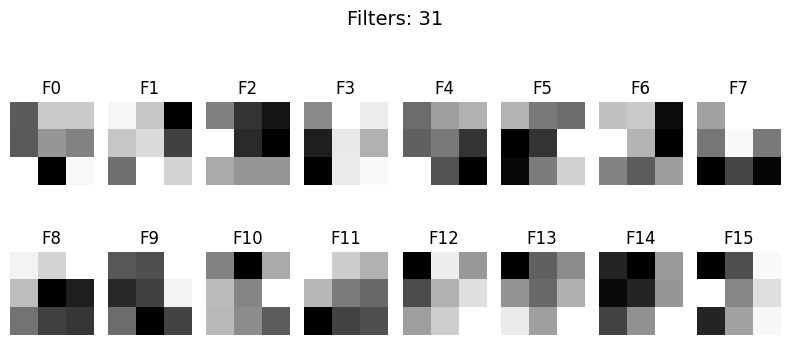

Layer: 34, Filter shape: (128, 128, 3, 3)


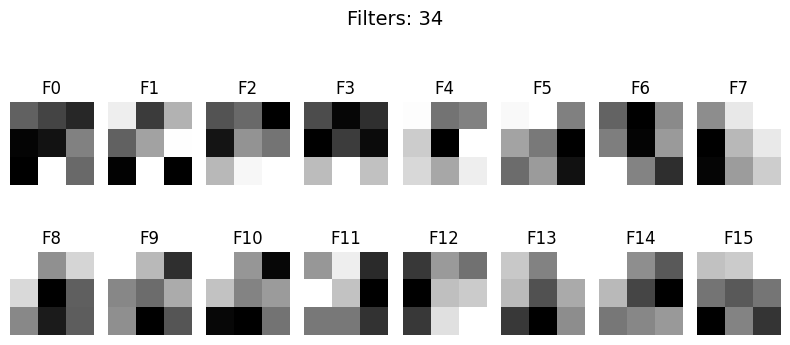

Layer: 39, Filter shape: (256, 128, 3, 3)


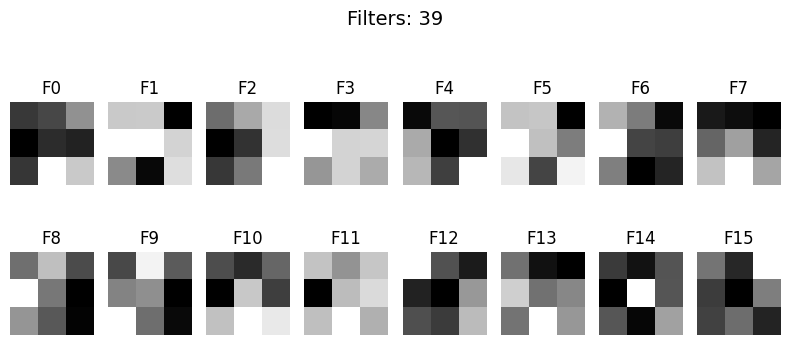

Layer: 42, Filter shape: (256, 256, 3, 3)


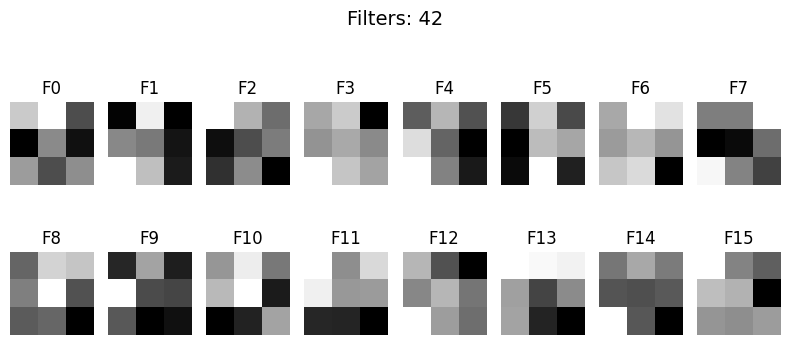

Layer: 47, Filter shape: (512, 256, 3, 3)


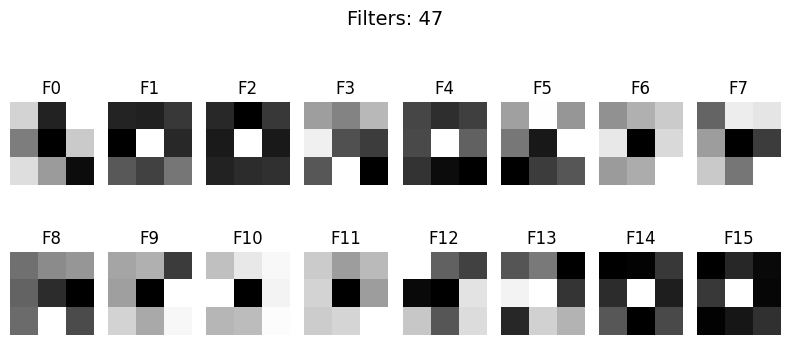

In [67]:
visualize_conv_filters(features_model)

### Feature Map Visualization

In addition, we will visualizes the **feature maps** (activation maps) produced by the convolutional layers when processing an input image.

**What it does:**
1. **Attaches hooks** to capture intermediate layer outputs during a forward pass
2. **Processes the image** through the network to generate activations
3. **Extracts and visualizes** the feature maps from selected layers
4. **Shows what patterns** each filter detected in the input image

In [68]:
def visualize_feature_maps(model, input_img, layer_names=None):
  feature_maps = {}

  def get_feature_map(name):
    def hook(module, input, output):
      feature_maps[name] = output.detach()
    return hook

  hooks = []
  for name, module in model.named_modules():
    if isinstance(module, nn.Conv2d) or isinstance(module, nn.BatchNorm2d):
      if layer_names is None or name in layer_names:
        hook = module.register_forward_hook(get_feature_map(name))
        hooks.append(hook)

  with torch.no_grad():
    _ = model(input_img.unsqueeze(0))

  for hook in hooks:
    hook.remove()

  for layer_name, maps in feature_maps.items():
    print(f"Layer: {layer_name}, Feature map shape: {maps.shape}")

    maps = maps[0]
    num_channels = min(16, maps.shape[0])

    fig, axes = plt.subplots(4, 4, figsize=(4, 4))
    fig.suptitle(f"Features Maps: {layer_name}", fontsize=12)

    for i, ax in enumerate(axes.flat):
      if i < num_channels:
        feature_map = maps[i].cpu().numpy()
        feature_map = (feature_map - feature_map.min()) / (feature_map.max() - feature_map.min() + 1e-8)

        ax.imshow(feature_map, cmap='viridis')
        ax.set_title(f"Channel {i}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()
  

Layer: 0, Feature map shape: torch.Size([1, 32, 28, 28])


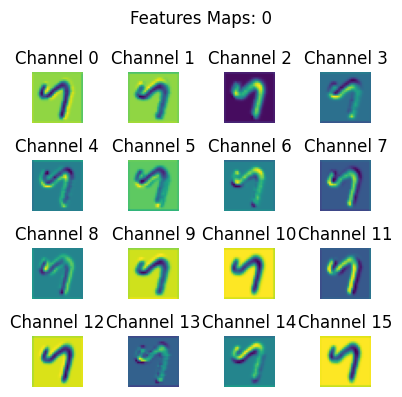

Layer: 1, Feature map shape: torch.Size([1, 32, 28, 28])


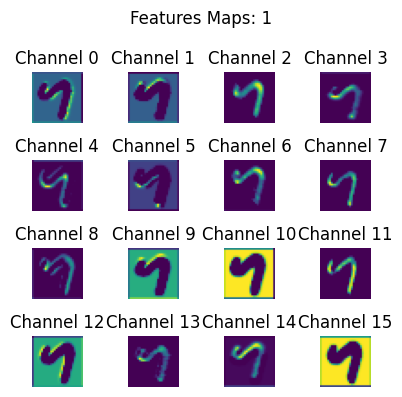

Layer: 3, Feature map shape: torch.Size([1, 32, 28, 28])


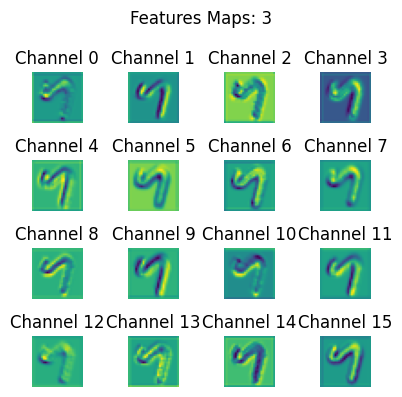

Layer: 4, Feature map shape: torch.Size([1, 32, 28, 28])


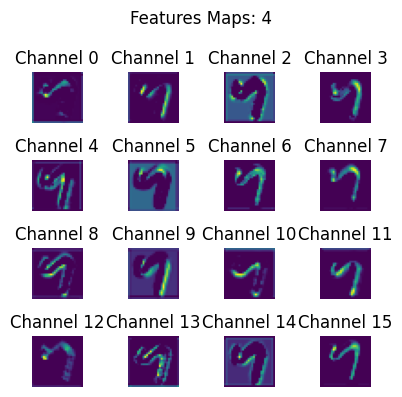

Layer: 6, Feature map shape: torch.Size([1, 32, 28, 28])


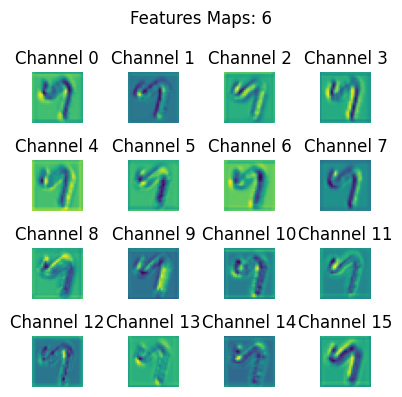

Layer: 7, Feature map shape: torch.Size([1, 32, 28, 28])


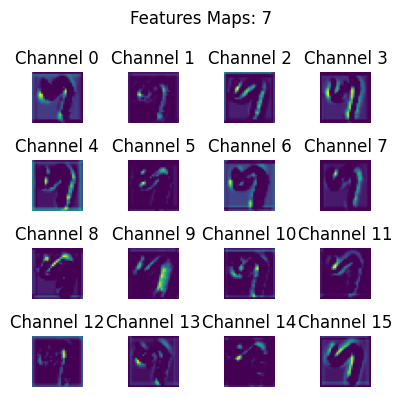

Layer: 9, Feature map shape: torch.Size([1, 32, 28, 28])


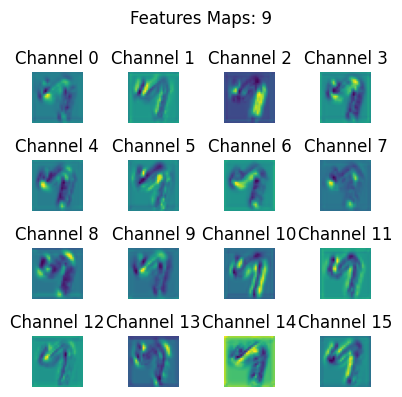

Layer: 10, Feature map shape: torch.Size([1, 32, 28, 28])


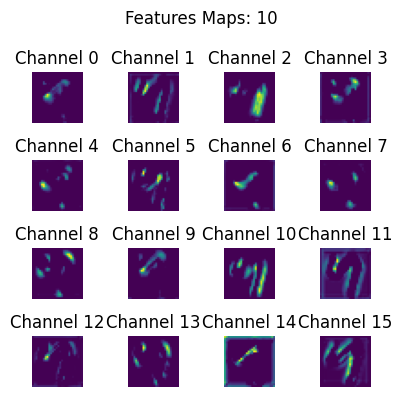

Layer: 14, Feature map shape: torch.Size([1, 64, 14, 14])


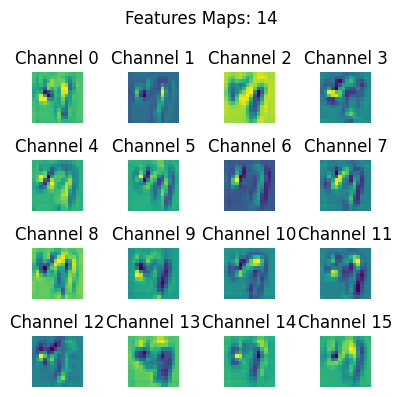

Layer: 15, Feature map shape: torch.Size([1, 64, 14, 14])


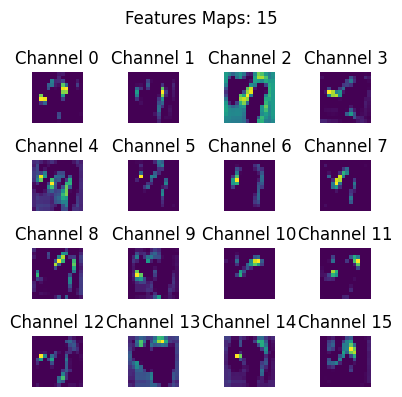

Layer: 17, Feature map shape: torch.Size([1, 64, 14, 14])


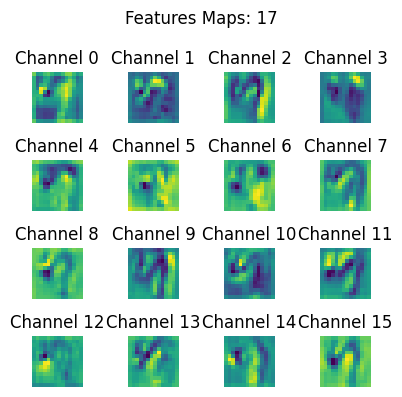

Layer: 18, Feature map shape: torch.Size([1, 64, 14, 14])


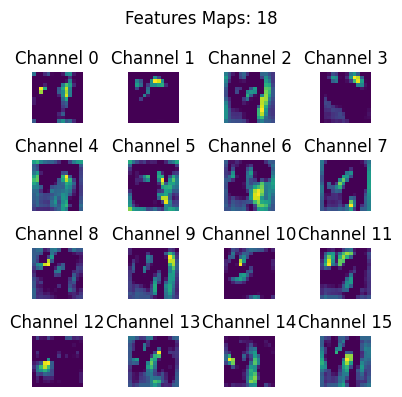

Layer: 20, Feature map shape: torch.Size([1, 64, 14, 14])


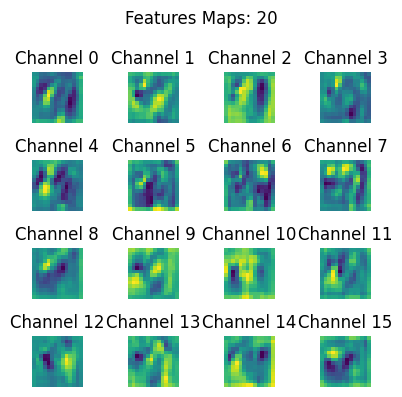

Layer: 21, Feature map shape: torch.Size([1, 64, 14, 14])


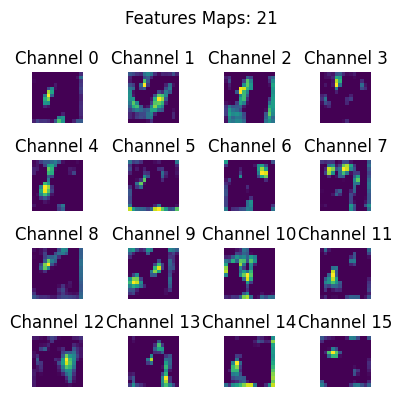

Layer: 23, Feature map shape: torch.Size([1, 64, 14, 14])


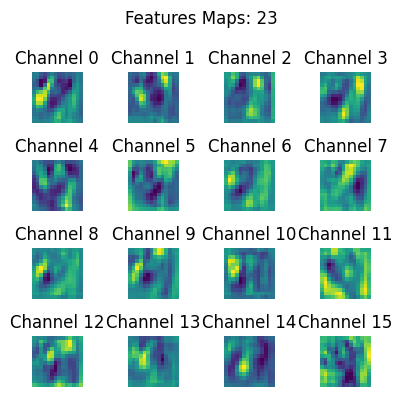

Layer: 24, Feature map shape: torch.Size([1, 64, 14, 14])


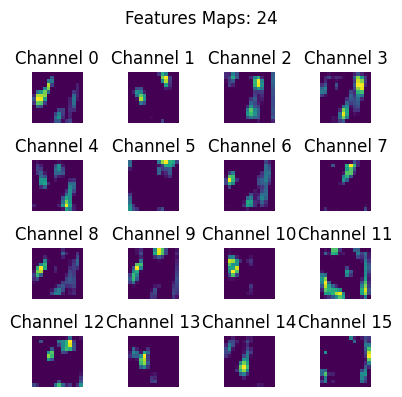

Layer: 28, Feature map shape: torch.Size([1, 128, 7, 7])


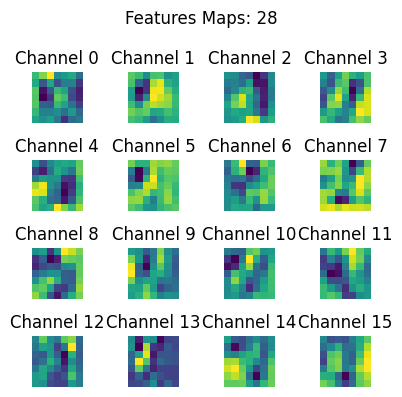

Layer: 29, Feature map shape: torch.Size([1, 128, 7, 7])


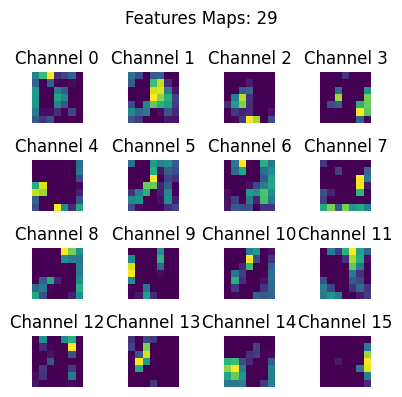

Layer: 31, Feature map shape: torch.Size([1, 128, 7, 7])


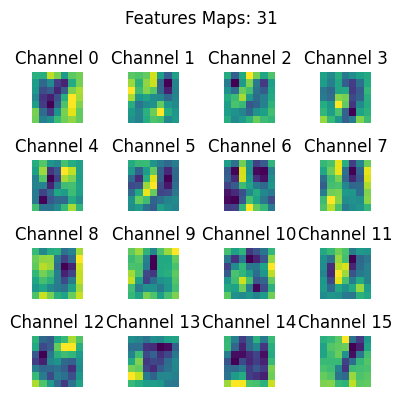

Layer: 32, Feature map shape: torch.Size([1, 128, 7, 7])


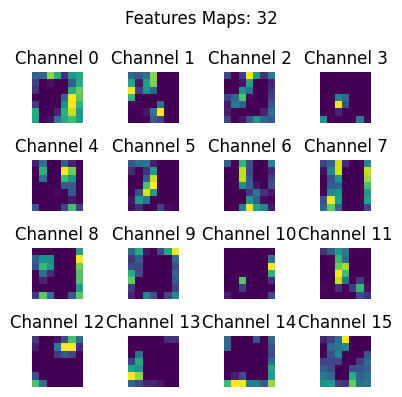

Layer: 34, Feature map shape: torch.Size([1, 128, 7, 7])


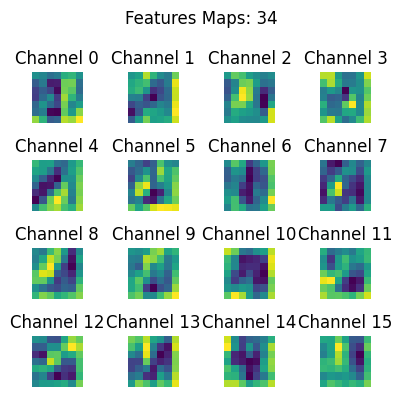

Layer: 35, Feature map shape: torch.Size([1, 128, 7, 7])


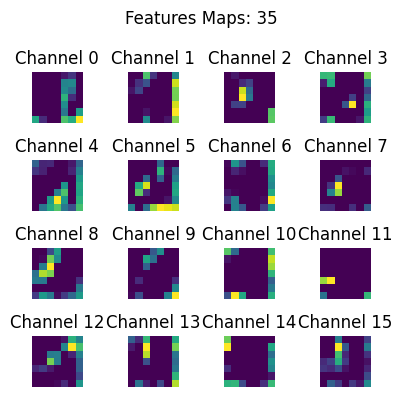

Layer: 39, Feature map shape: torch.Size([1, 256, 3, 3])


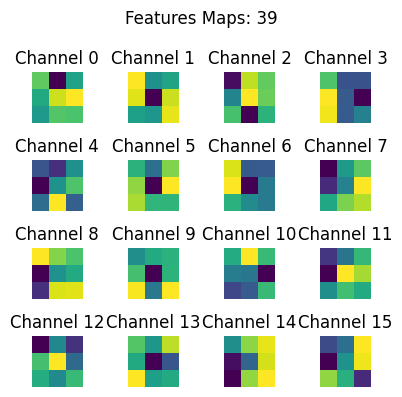

Layer: 40, Feature map shape: torch.Size([1, 256, 3, 3])


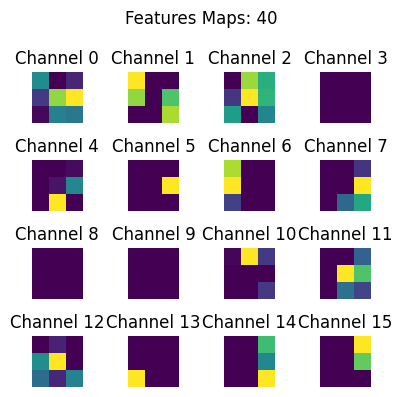

Layer: 42, Feature map shape: torch.Size([1, 256, 3, 3])


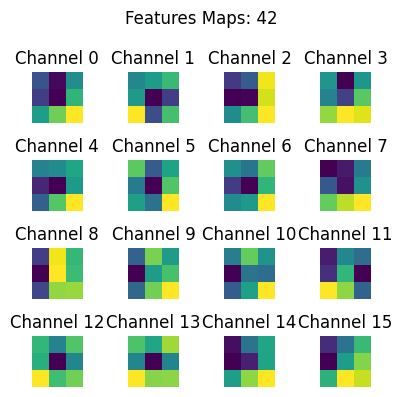

Layer: 43, Feature map shape: torch.Size([1, 256, 3, 3])


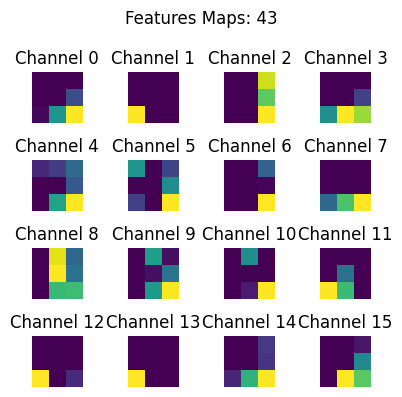

Layer: 47, Feature map shape: torch.Size([1, 512, 1, 1])


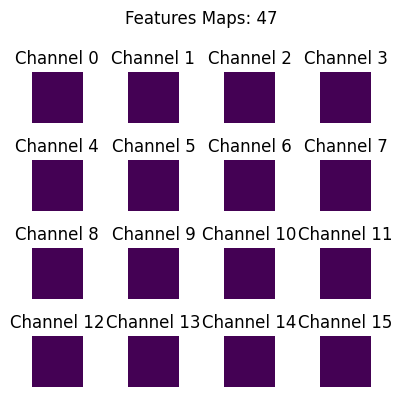

Layer: 48, Feature map shape: torch.Size([1, 512, 1, 1])


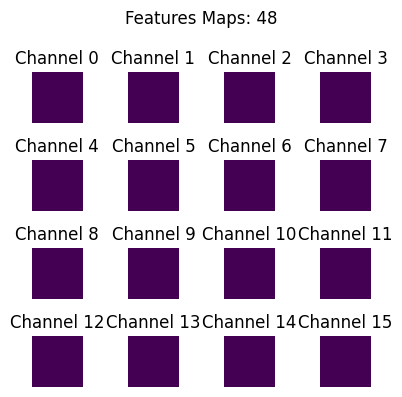

In [69]:
sample_img, _ = next(iter(train_loader))
visualize_feature_maps(features_model, sample_img[0].to(device))

It reveals how the network "sees" the image at different layers - early layers detect simple edges and textures, while deeper layers detect more complex patterns and features.

### Grad-CAM (Gradient-weighted Class Activation Mapping)

Using **Grad-CAM** to visualize which parts of an image the model focuses on when making predictions.

**What it does:**
* **Attaches hooks** to capture feature maps and gradients from the last convolutional layer
* **Runs forward pass** to get model predictions
* **Performs backward pass** to calculate gradients for the target class
* **Computes importance weights** by averaging gradients spatially
* ***Generates heatmap** by combining feature maps with importance weights
* ***Overlays heatmap** on original image to show important regions

In [75]:
class FullModel(nn.Module):
    def __init__(self, features, classifier):
        super().__init__()
        self.features = features
        self.classifier = classifier

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)   # flatten feature maps
        x = self.classifier(x)
        return x

In [86]:
full_model = FullModel(features_model, classifier_model).to(device)
full_model

FullModel(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): Dropout(p=0.25, inplace=False)
    (14): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=

In [ ]:
def grad_cam(model, input_image, target_class=None):
    """
    Generate Grad-CAM to see which regions are important for classification
    """
    # Hook for feature maps and gradients
    feature_maps = {}
    gradients = {}

    
    def forward_hook(module, input, output):
        feature_maps['value'] = output.detach()
    
    def backward_hook(module, grad_input, grad_output):
        gradients['value'] = grad_output[0].detach()
    
    # Register hooks on the last convolutional layer
    target_layer = None
    # for name, module in model.named_modules():
    #     if isinstance(module, nn.Conv2d):
    #         target_layer = module
    
    # if target_layer is None:
    #     print("No convolutional layer found!")
    #     return

    target_layer = model.features[42]

    forward_handle = target_layer.register_forward_hook(forward_hook)
    backward_handle = target_layer.register_backward_hook(backward_hook)
    
    # Forward pass
    output = model(input_image.unsqueeze(0))
  
    if target_class is None:
        target_class = output.argmax(dim=1).item()

    # Backward pass
    model.zero_grad()
    one_hot = torch.zeros_like(output)
    one_hot[0, target_class] = 1
    output.backward(gradient=one_hot)
    
    # Compute Grad-CAM
    maps = feature_maps['value']
    grads = gradients['value']
    
    weights = grads.mean(dim=(2, 3), keepdim=True)
    cam = (weights * maps).sum(dim=1, keepdim=True)
    cam = torch.relu(cam)  # ReLU to keep only positive influences
    
    # Normalize
    cam = cam - cam.min()
    cam = cam / cam.max()
    
    # Remove hooks
    forward_handle.remove()
    backward_handle.remove()

    # print(cam)
    
    return cam.squeeze().cpu().numpy(), target_class



torch.Size([28, 28])
torch.Size([1, 3, 3])


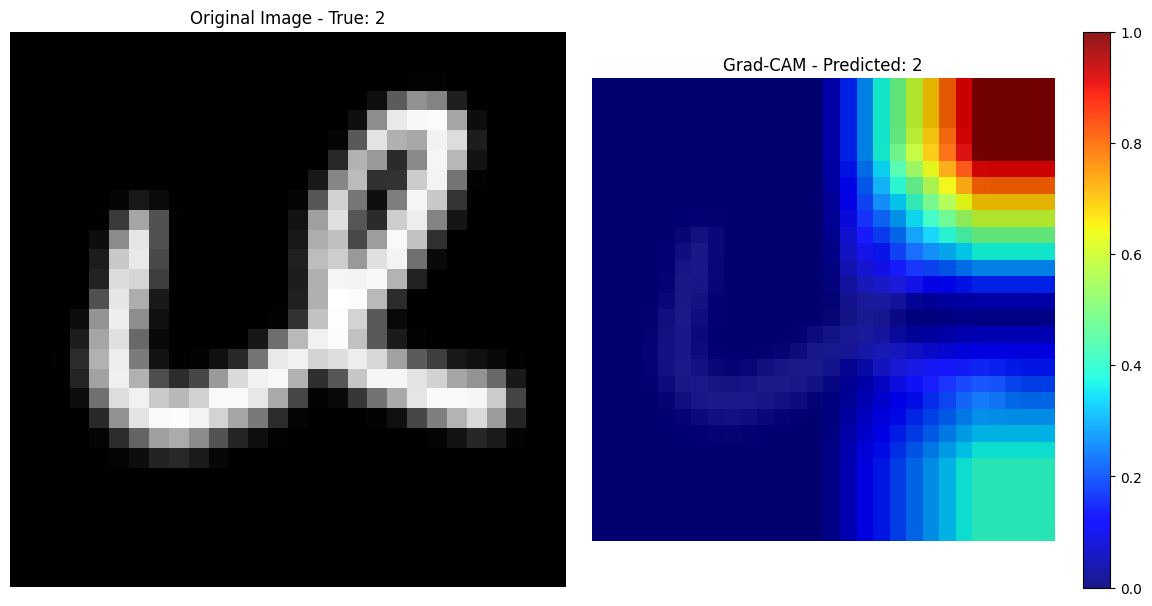

In [107]:
# Usage
sample_image, true_label = next(iter(val_loader))
sample_image = sample_image[0].to(device)

H, W = sample_image.shape[1:]
full_model.eval()
cam, predicted_class = grad_cam(full_model, sample_image)
# print(cam.shape, sample_image)
cam_tensor = torch.tensor(cam).unsqueeze(0).unsqueeze(0)
cam_resized = F.interpolate(cam_tensor, size=(H, W), mode='bilinear', align_corners=False)
cam_resized = cam_resized.squeeze().cpu().numpy()

print(sample_image.shape[1:])
print(cam_tensor.shape[1:])

# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Original image
ax1.imshow(sample_image.squeeze().cpu().numpy(), cmap='gray')
ax1.set_title(f'Original Image - True: {true_label[0]}')
ax1.axis('off')

# Grad-CAM
ax2.imshow(sample_image.squeeze().cpu().numpy(), cmap='gray')
im = ax2.imshow(cam_resized, cmap='jet', alpha=0.9)
ax2.set_title(f'Grad-CAM - Predicted: {predicted_class}')
ax2.axis('off')

plt.colorbar(im, ax=ax2)
plt.tight_layout()
plt.show()


It creates a visual explanation showing which image areas most influenced the model's decision.

### Weight Visualization for Linear Layers
Visualize Weight Distributions: examine layer weights and feature influence, and detect training problems like saturation or dead neurons.

In [108]:
def visualize_classifier_weights(classifier_model, feature_names=None):
    """
    Visualize weights of linear layers to see feature importance
    """
    for name, module in classifier_model.named_modules():
        if isinstance(module, nn.Linear):
            weights = module.weight.data.cpu().numpy()
            print(f"Layer: {name}, Weight shape: {weights.shape}")
            
            # Visualize weight matrix as heatmap
            plt.figure(figsize=(8, 4))
            
            if weights.shape[1] <= 256:  # Only if input features are reasonable to visualize
                plt.imshow(weights, cmap='RdBu_r', aspect='auto')
                plt.colorbar()
                plt.title(f'Weight Matrix: {name}\n{weights.shape[0]} neurons × {weights.shape[1]} features')
                plt.xlabel('Input Features')
                plt.ylabel('Output Neurons')
            else:
                # For large weight matrices, show distribution
                plt.hist(weights.flatten(), bins=50, alpha=0.7, edgecolor='black', color='blue')
                plt.axvline(0, color='orange', linestyle='--')
                plt.title(f'Weight Distribution: {name}\nMean: {weights.mean():.4f}, Std: {weights.std():.4f}')
                plt.xlabel('Weight Value')
                plt.ylabel('Frequency')
            
            plt.tight_layout()
            plt.show()

Layer: 0, Weight shape: (512, 2048)


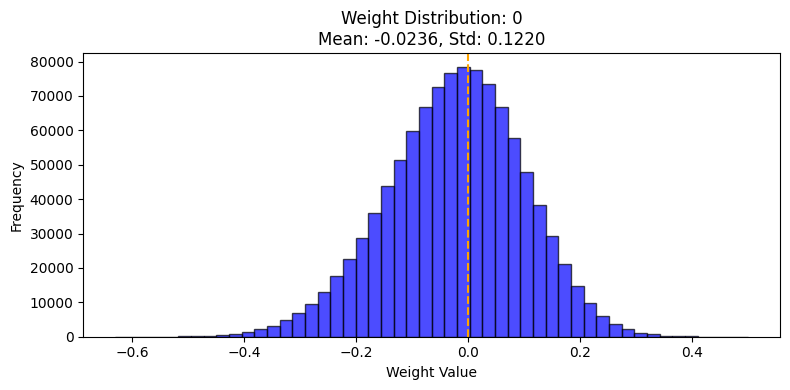

Layer: 4, Weight shape: (256, 512)


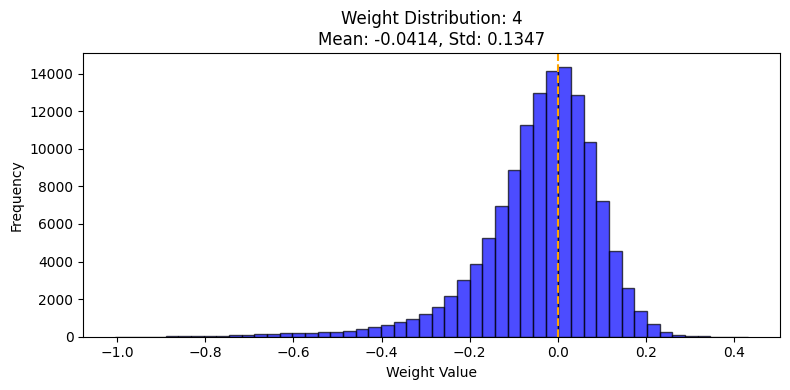

Layer: 8, Weight shape: (62, 256)


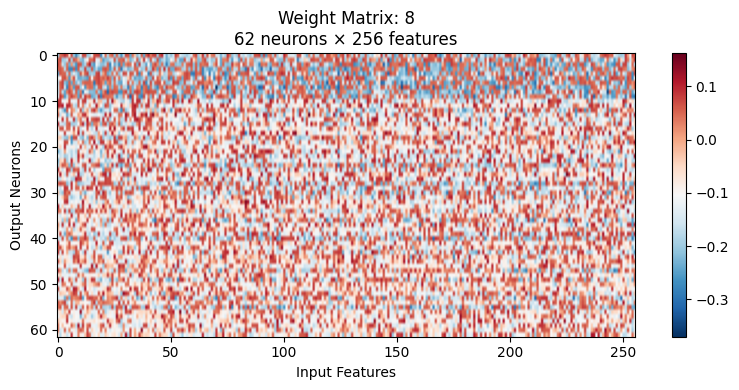

In [109]:
# Usage
visualize_classifier_weights(classifier_model)

* **Distribution**: Healthy layers have weights centered around zero with moderate spread; strong bias or saturation signals issues.

* **Feature importance**: High-magnitude columns show influential features; varied rows reveal neurons responsive to specific inputs.

* **Color meaning**:  
  * Red = positive connection
  * Blue = negative connection
  * White/gray = neutral

### Feature Importance Analysis
See Which Features Most Influence Decisions

Analyzes which features from the feature extractor are most important for the classifier's decisions.

**What it does:**
* **Collects features** and predictions from multiple test samples
* **Examines the weights** of the first linear layer in the classifier
* **Identifies top features** that have the strongest influence on each class
* **Visualizes feature importance** showing which feature dimensions matter most for different characters

(62, 256)


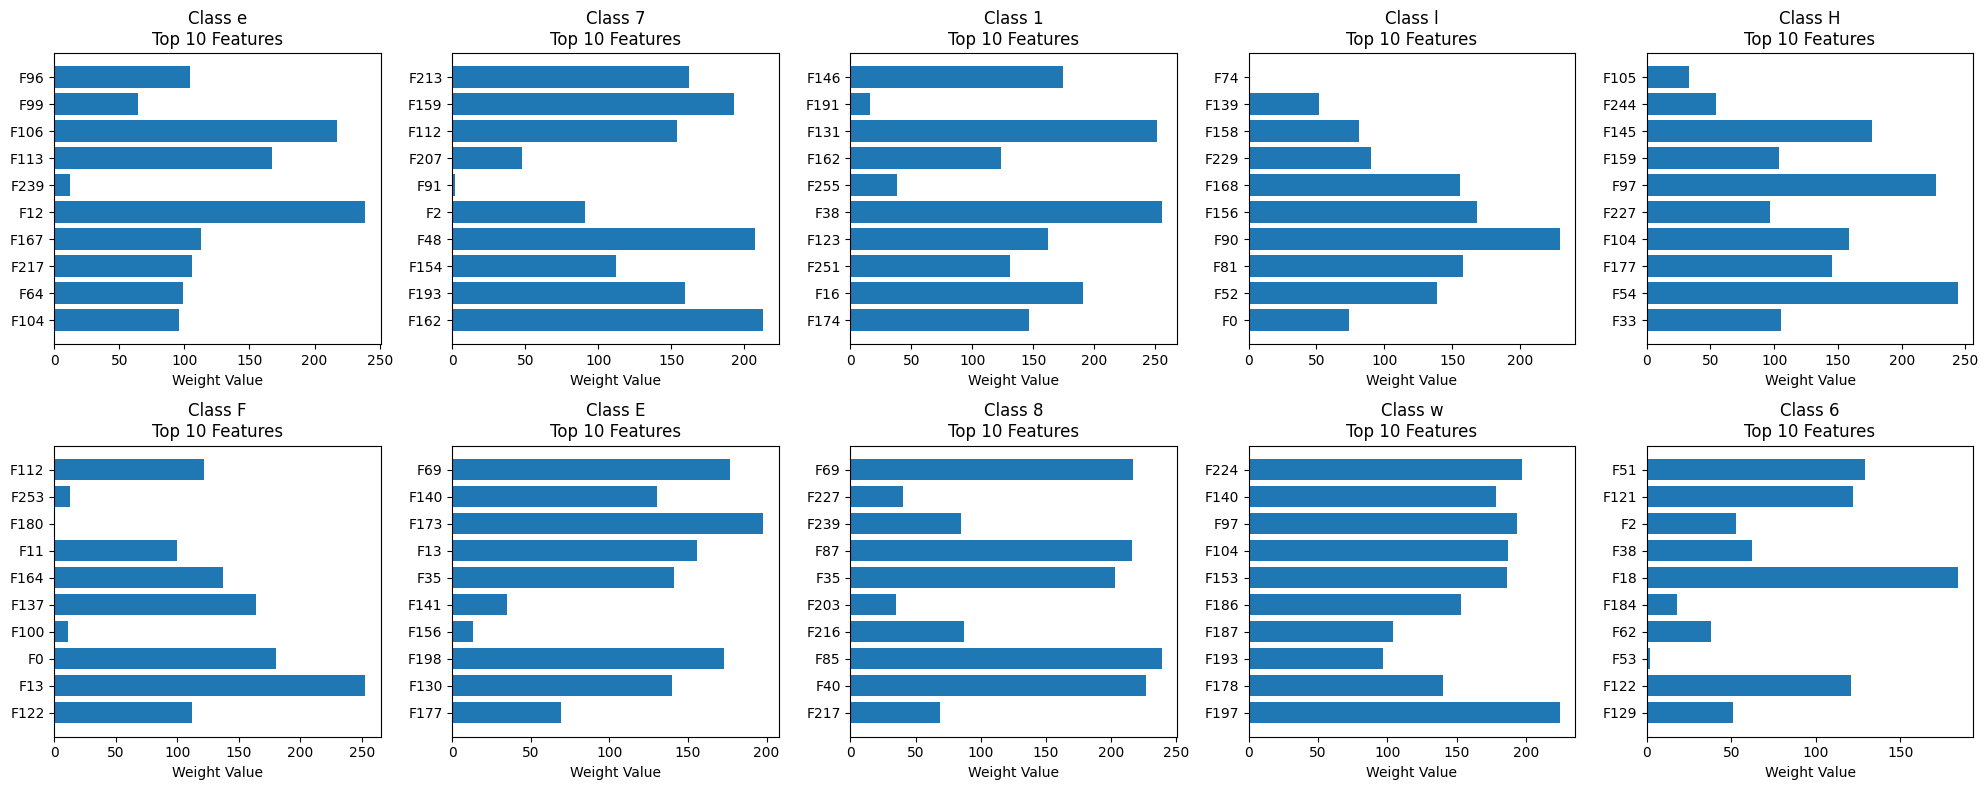

In [110]:
def analyze_feature_importance(features_model, classifier_model, test_loader, class_names, n_samples=100):
    """
    Analyze which features from the feature extractor are most important for classification
    """
    features_model.eval()
    classifier_model.eval()
    
    all_features = []
    all_predictions = []
    all_labels = []
    
    # Collect features and predictions
    with torch.no_grad():
        for i, (data, targets) in enumerate(test_loader):
            if i * data.size(0) >= n_samples:
                break
                
            data, targets = data.to(device), targets.to(device)
            
            # Get features before classifier
            features = features_model(data)
            features_flat = features.view(features.size(0), -1)
            
            # Get predictions
            outputs = classifier_model(features_flat)
            predictions = outputs.argmax(dim=1)
            
            all_features.append(features_flat.cpu())
            all_predictions.append(predictions.cpu())
            all_labels.append(targets.cpu())
    
    # Concatenate all batches
    all_features = torch.cat(all_features, dim=0)
    all_predictions = torch.cat(all_predictions, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    
    # Analyze weights of linear layer
    first_linear = None
    for module in classifier_model.modules():
        if isinstance(module, nn.Linear):
            first_linear = module
            # break
    
    if first_linear is not None:
        weights = first_linear.weight.data.cpu().numpy()  # Shape: (output_features, input_features)
        print(weights.shape)
        n_classes = weights.shape[0]
        random_classes_list = random.sample(range(n_classes), 10)
        n_top_features = 10
        
        fig, axes = plt.subplots(2, (len(random_classes_list) + 1) // 2, figsize=(20, 8))
        axes = axes.flatten()
        
        # Get top features for each class
        for idx, class_idx in enumerate(random_classes_list):
            class_weights = weights[class_idx]
            
            # Get top positive and negative features
            top_positive_idx = np.argsort(class_weights)[-n_top_features:][::-1]
            top_negative_idx = np.argsort(class_weights)[:n_top_features]
            
            # Plot feature importance
            ax = axes[idx]
            sorted_idx = np.argsort(class_weights)
            # ax.barh(range(20), class_weights[sorted_idx[-20:]])
            ax.barh(range(n_top_features), top_positive_idx)
            ax.set_yticks(range(n_top_features))
            ax.set_yticklabels([f'F{sorted_idx[-n_top_features:][i]}' for i in range(n_top_features)])
            ax.set_title(f'Class {class_names[class_idx]}\nTop {n_top_features} Features')
            ax.set_xlabel('Weight Value')
        
        # Hide empty subplots
        for i in range(n_classes, len(axes)):
            axes[i].set_visible(False)
        
        plt.tight_layout()
        plt.show()
    
    return all_features.numpy(), all_predictions.numpy(), all_labels.numpy()

# Usage
features, predictions, labels = analyze_feature_importance(
    features_model, classifier_model, val_loader, EMNIST_MAPPING
)

### Confidence Distribution Analysis

Analyzes the model's prediction confidence to understand how certain it is about its decisions.

* **Collects confidence scores** for all test predictions using softmax probabilities
* **Compares confidence levels** between correct and incorrect predictions
* **Analyzes confidence patterns** across different character classes
* **Visualizes confidence distributions** through multiple plots

In [111]:
def analyze_classifier_confidence(features_model, classifier_model, test_loader, class_names):
    """
    Analyze how confident the classifier is for different classes
    """
    features_model.eval()
    classifier_model.eval()
    
    all_confidences = []
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for data, targets in test_loader:
            data, targets = data.to(device), targets.to(device)
            
            features = features_model(data)
            features_flat = features.view(features.size(0), -1)
            outputs = classifier_model(features_flat)
            probabilities = torch.softmax(outputs, dim=1)
            confidences, predictions = probabilities.max(dim=1)
            
            all_confidences.append(confidences.cpu())
            all_predictions.append(predictions.cpu())
            all_labels.append(targets.cpu())
    
    all_confidences = torch.cat(all_confidences).numpy()
    all_predictions = torch.cat(all_predictions).numpy()
    all_labels = torch.cat(all_labels).numpy()
    
    # Plot confidence distributions
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.hist(all_confidences, bins=50, alpha=0.7, edgecolor='black')
    plt.xlabel('Confidence')
    plt.ylabel('Frequency')
    plt.title('Overall Confidence Distribution')
    
    plt.subplot(1, 3, 2)
    correct_mask = (all_predictions == all_labels)
    plt.hist(all_confidences[correct_mask], bins=50, alpha=0.7, label='Correct', edgecolor='green')
    plt.hist(all_confidences[~correct_mask], bins=50, alpha=0.7, label='Incorrect', edgecolor='red')
    plt.xlabel('Confidence')
    plt.ylabel('Frequency')
    plt.title('Confidence by Prediction Correctness')
    plt.legend()
    
    plt.subplot(1, 3, 3)
    # Average confidence per class
    class_avg_confidence = []
    for class_idx in range(len(class_names)):
        class_mask = (all_predictions == class_idx)
        if class_mask.any():
            avg_conf = all_confidences[class_mask].mean()
            class_avg_confidence.append(avg_conf)
        else:
            class_avg_confidence.append(0)
    
    plt.bar(range(len(class_names)), class_avg_confidence)
    plt.xlabel('Class')
    plt.ylabel('Average Confidence')
    plt.title('Average Confidence per Predicted Class')
    plt.xticks(range(len(class_names)), class_names, rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    accuracy = (all_predictions == all_labels).mean()
    print(f"Overall Accuracy: {accuracy:.4f}")
    print(f"Average Confidence: {all_confidences.mean():.4f}")
    print(f"Confidence Std: {all_confidences.std():.4f}")



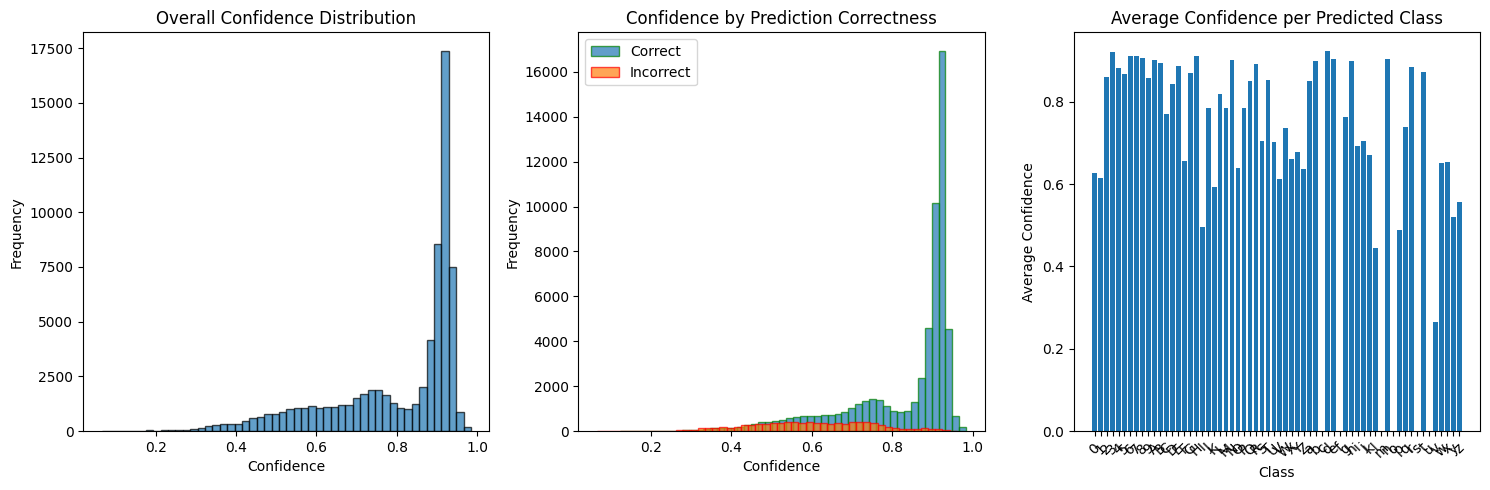

Overall Accuracy: 0.8679
Average Confidence: 0.8012
Confidence Std: 0.1612


In [89]:
analyze_classifier_confidence(features_model, classifier_model, val_loader, EMNIST_MAPPING)

Reveals whether the model is overconfident, underconfident, or well-calibrated, and identifies which classes the model finds most challenging or easy to recognize.